# Word and feature embeddings

In this notebook, we wish to explore and experiement with feature embeddings, more specifically word embeddings, for use in our neural classification approaches. Technologies such as word2vec and fastText have been proven to increase the effectiveness of neural models by moving from a BOW model to word and sentence relationship vector representations. The first of these we will look at is word2vec, a breakthrough 2 layer neural network algorithm patented by Google that turns a corpus of text into a vocab of word embeddings.

There are two types of this algorithm: CBOW and skip-gram. 

To do this, we will use the gensim library. We will demonstrate word2vec using our smaller corpus, OpSpam, and apply it to our Yelp datasets in the future.

In [1]:
import gensim
from scripts import training_helpers
import numpy as np
import re

df = training_helpers.get_data_frame()
reviews = df['review'] # Gets our dataset in a Pandas data frame
print(reviews.head()) 
sentences = [[re.sub(r'\W+', ' ', x).lower().strip() for x in review.split()] for review in reviews] # Tokenizes our reviews
print(sentences[1])

0    We stayed at the Schicago Hilton for 4 days an...
1    Hotel is located 1/2 mile from the train stati...
2    I made my reservation at the Hilton Chicago be...
3    When most people think Hilton, they think luxu...
4    My husband and I recently stayed stayed at the...
Name: review, dtype: object
['hotel', 'is', 'located', '1 2', 'mile', 'from', 'the', 'train', 'station', 'which', 'is', 'quite', 'hike', 'when', 'you re', 'traveling', 'with', 'luggage', 'and or', 'kids', 'they', 'seem', 'to', 'cash', 'in', 'on', 'guests', 'who', 'arrive', 'in', 'private', 'car', 'by', 'charging', 'exorbitant', 'parking valet', 'fees', 'rooms', 'feature', 'either', 'double', 'or', 'king', 'sized', 'beds', 'no', 'queen', 'beds', 'at', 'all', 'if', 'you', 'want', 'a', 'little', 'extra', 'leg', 'room', 'in', 'your', 'bed', 'the', 'price', 'jump', 'from', 'double', 'to', 'king sized', 'is', 'stiff', 'rooms', 'with', 'any', 'kind', 'of', 'view', 'pay', 'a', 'healthy', 'surcharge', 'too']


Now, lets use word2Vec on our reviews. We set min_words = 2, so that only words that appear a minimum of twice appear, to filter out any crappy typos. Size = 100 is the dimensionality of the vectors, which was empirically found to be 100 in studies. Workers is simply how many cores to use.

In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model_w2v = Word2Vec(sentences, min_count = 3, size = 100, workers = 8, sg=1)
model_w2v.save("opspam_w2v.model")
words = model_w2v.wv.vocab

Now that we have our dataset in word vectors, let's explore the data a bit.

Let's see how many words had a minimum count of 2, firstly.

In [3]:
print(len(words))

4031


Roughly half of the words appear a minimum of twice, indicating a lot of typos and useless words.

Let's see how accurate it models word relationships. 

In [4]:
model_w2v.wv.most_similar('hilton')

[('fairmont', 0.9455259442329407),
 ('palmer', 0.9451866745948792),
 ('conrad', 0.9352377653121948),
 ('regency', 0.9314256906509399),
 ('intercontinental', 0.9298962354660034),
 ('homewood', 0.9278547763824463),
 ('hyatt', 0.9269102215766907),
 ('james', 0.9136669039726257),
 ('recent', 0.9074057340621948),
 ('omni', 0.9067708253860474)]

This is really cool, as all the most related words to 'Hilton' are other names of hotels.

Let's plot a visualization of the relationships of these words using PCA.

Because our previous word2vec vector is 8000 in size, let's up the min_count to make it much smaller for visualization purposes. 

In [5]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

508


/Users/niallwalsh/miniconda3/envs/lucas/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


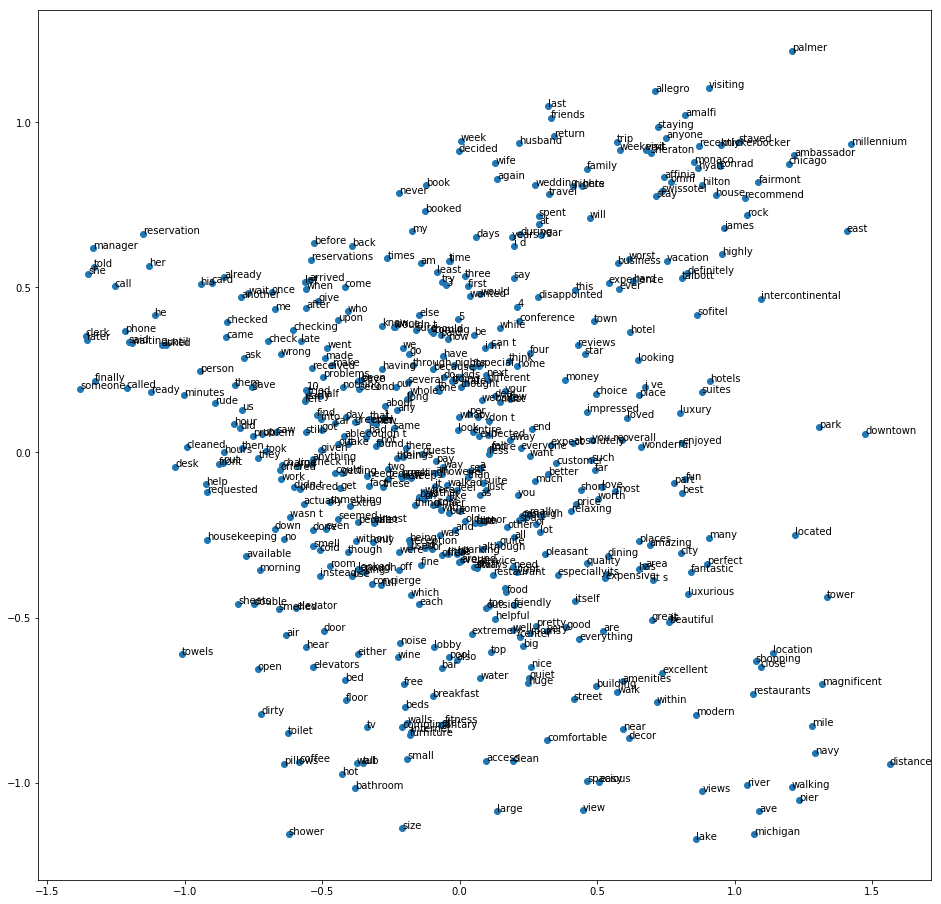

In [6]:
model_w2v = Word2Vec(sentences, min_count = 60, size = 100, workers = 8, sg=1)
words = model_w2v.wv.vocab
print(len(words))
X = model_w2v[words]

pca = PCA()

result = pca.fit_transform(X)

# create a scatter plot of the projection
figure(figsize=(16,16))
plt.scatter(result[:, 0], result[:, 1])
words = list(model_w2v.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Now let's try Facebook's fastText.

In [7]:
from gensim.models import FastText
model_ft = FastText(sentences, size=100, min_count=3, workers=8, sg=1)
model_ft.save("opspam_ft.model")

In [19]:
model_ft.wv.most_similar("wine")

[('cocktail', 0.9595194458961487),
 ('cockroach', 0.9566332697868347),
 ('glass', 0.9528090953826904),
 ('scene', 0.9506417512893677),
 ('bottle', 0.9466879367828369),
 ('minibar', 0.9464755654335022),
 ('cocktails', 0.9457591772079468),
 ('mini bar', 0.945457398891449),
 ('compliments', 0.9445778131484985),
 ('storage', 0.9436350464820862)]

In [9]:
embedding_matrix = np.zeros((len(model_ft.wv.vocab) + 1, 100))
for i in range(len(model_ft.wv.vocab)):
    embedding_vector = model_ft.wv[model_ft.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
print(embedding_matrix)

[[ 0.06682102  0.07675886  0.06815141 ... -0.09594598  0.09929439
  -0.01856869]
 [ 0.08840906  0.13072751  0.02505748 ... -0.32938331  0.1119146
   0.05646156]
 [ 0.42513278  0.28567046  0.15120028 ... -0.03181111  0.30663621
  -0.2091855 ]
 ...
 [ 0.13764758  0.13060801  0.02313894 ... -0.03745821 -0.07901014
   0.11543415]
 [ 0.04562913  0.01956642  0.06588233 ...  0.03236007 -0.07938918
   0.08462037]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
